# The Performance Of Models Trained On The MNIST Dataset On Custom-Drawn Images

In [1]:
import numpy as np
import tensorflow as tf
import sklearn, sklearn.linear_model, sklearn.multiclass, sklearn.naive_bayes
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams.update({'font.size': 12})

## Defining the data

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

### Making 1D versions of the MNIST images for the one-vs-rest classifier

In [4]:
train_images_flat = train_images.reshape((train_images.shape[0], train_images.shape[1] * train_images.shape[2])) / 255.0

test_images_flat = test_images.reshape((test_images.shape[0], test_images.shape[1] * test_images.shape[2])) / 255.0

### Making a 4D dataset and categorical labels for the neural net

In [5]:
train_images = np.expand_dims(train_images, axis=-1) / 255.0
test_images = np.expand_dims(test_images, axis=-1) / 255.0

#train_images = train_images.reshape(60000, 28, 28, 1)
#test_images = test_images.reshape(10000, 28, 28, 1)

train_labels_cat = tf.keras.utils.to_categorical(train_labels)
test_labels_cat = tf.keras.utils.to_categorical(test_labels)

In [6]:
def plot_images(images, labels, rows=5, cols=5, label='Label'):    
    fig, axes = plt.subplots(rows, cols)
    fig.figsize=(15, 15)    

    indices = np.random.choice(len(images), rows * cols)
    counter = 0

    for i in range(rows):
        for j in range(cols):
            axes[i, j].imshow(images[indices[counter]])
            axes[i, j].set_title(f"{label}: {labels[indices[counter]]}")
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            counter += 1
    
    plt.tight_layout()
    plt.show()

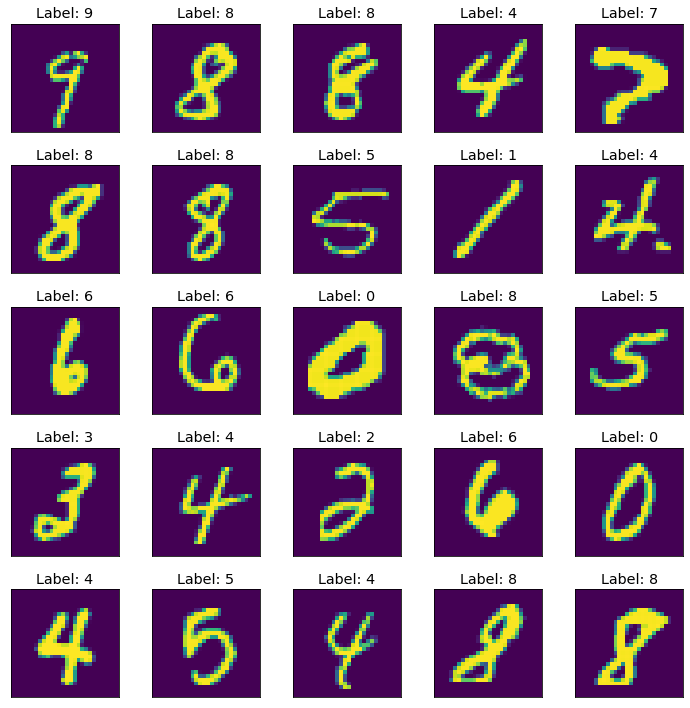

In [7]:
plot_images(train_images, train_labels)

## Training

### Defining and training the one-vs-rest classifier

In [8]:
log_reg = sklearn.linear_model.SGDClassifier(loss='log', max_iter=1000, penalty='l2')

classifier = sklearn.multiclass.OneVsRestClassifier(log_reg)

classifier.fit(train_images_flat, train_labels)

OneVsRestClassifier(estimator=SGDClassifier(loss='log'))

### Defining and training the neural net

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [10]:
def create_model():
    model = Sequential([
        layers.Conv2D(64, 5, activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPool2D(2),
        layers.Conv2D(128, 5, activation='relu'),
        layers.MaxPool2D(2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
model = create_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 207,882
Trainable params: 207,882
Non-trainable params: 0
__________________________________________________

In [13]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.3,
                                                           height_shift_range=0.10,
                                                           width_shift_range=0.10,
                                                           rotation_range=10)

train_datagen = train_gen.flow(train_images, train_labels_cat, batch_size=256)

'''def scheduler(epoch):    
    initial_lr = 0.001
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

from tensorflow.keras.callbacks import LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)'''

'def scheduler(epoch):    \n    initial_lr = 0.001\n    lr = initial_lr * np.exp(-0.1 * epoch)\n    return lr\n\nfrom tensorflow.keras.callbacks import LearningRateScheduler\nlr_scheduler = LearningRateScheduler(scheduler, verbose=1)'

In [14]:
history = model.fit(train_datagen, initial_epoch=0, epochs=30, batch_size=256,
                         validation_data=(test_images, test_labels_cat))

Epoch 1/30
235/235 [==============================] - 15s 55ms/step - loss: 1.0590 - accuracy: 0.6757 - val_loss: 0.2701 - val_accuracy: 0.9319
Epoch 2/30
235/235 [==============================] - 13s 54ms/step - loss: 0.4189 - accuracy: 0.8813 - val_loss: 0.1617 - val_accuracy: 0.9566
Epoch 3/30
235/235 [==============================] - 13s 53ms/step - loss: 0.3105 - accuracy: 0.9123 - val_loss: 0.1374 - val_accuracy: 0.9592
Epoch 4/30
235/235 [==============================] - 13s 54ms/step - loss: 0.2602 - accuracy: 0.9252 - val_loss: 0.0984 - val_accuracy: 0.9728
Epoch 5/30
235/235 [==============================] - 13s 54ms/step - loss: 0.2215 - accuracy: 0.9368 - val_loss: 0.0929 - val_accuracy: 0.9718
Epoch 6/30
235/235 [==============================] - 13s 53ms/step - loss: 0.1958 - accuracy: 0.9436 - val_loss: 0.0849 - val_accuracy: 0.9737
Epoch 7/30
235/235 [==============================] - 13s 53ms/step - loss: 0.1724 - accuracy: 0.9498 - val_loss: 0.0593 - val_accuracy:

In [15]:
model.save('cnn-64-128-5-aug')
#model.load_weights('cnn-64-128-5-aug')

INFO:tensorflow:Assets written to: cnn-64-128-5-aug\assets


## Assessing model performance

### Loading drawn images

In [16]:
def read_images(filepaths, reverse=False):
    images = []
    images_flat = []
    
    for filepath in filepaths:
        image = tf.io.read_file(filepath)
        image = tf.image.decode_image(image, channels=1)
        image = tf.image.resize(image, (28, 28))
        
        if reverse:        
            image = np.where(image == 255, 0, 255)
        else:
            image = image.numpy()
        
        image = image / 255.0        
        images.append(image)
        
        images_flat.append(image.reshape(28 * 28))      
    
    return np.array(images), np.array(images_flat)

In [17]:
filepaths = tf.io.gfile.glob('images/*.png')

list.sort(filepaths, key=lambda x: int(x[12:-4]))

images, images_flat = read_images(filepaths, True)

In [18]:
images.shape

(1013, 28, 28, 1)

### Creating labels for the one-vs-rest classifier and the neural net

In [19]:
labels = 100 * [0] + 98 * [1] + 100 * [2] + 101 * [3] + 99 * [4] + 111 * [5] + 89 * [6] + 110 * [7] + 93 * [8] + 112 * [9]

labels = np.array(labels)

In [20]:
labels.shape

(1013,)

In [21]:
labels_cat = tf.keras.utils.to_categorical(labels)

labels_cat.shape

(1013, 10)

In [22]:
labels_cat[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Plotting the drawn images and their corresponding labels

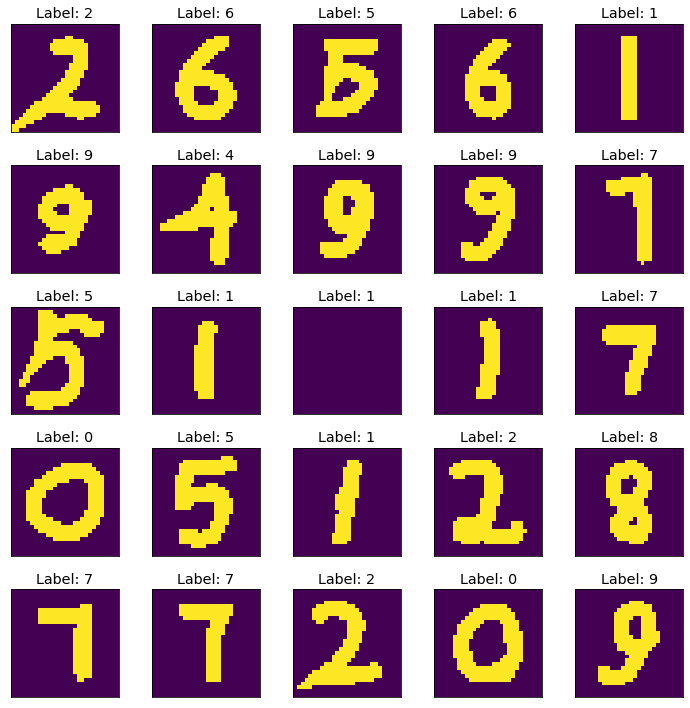

In [23]:
plot_images(images, labels)

### Evaluating model performance

#### Neural net on MNIST test dataset

In [24]:
model.evaluate(test_images, test_labels_cat)

313/313 [==============================] - 1s 3ms/step - loss: 0.0364 - accuracy: 0.9887


[0.036382365971803665, 0.9886999726295471]

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = np.argmax(model.predict(test_images), axis=-1)

conf_mat = confusion_matrix(test_labels, predictions) 

In [26]:
conf_mat

array([[ 963,    0,    2,    0,    0,    0,    2,    1,    9,    3],
       [   1, 1117,    2,    5,    0,    1,    0,    5,    4,    0],
       [   0,    0, 1022,    3,    0,    0,    0,    3,    3,    1],
       [   0,    0,    1, 1003,    0,    3,    0,    0,    2,    1],
       [   0,    0,    1,    0,  966,    0,    0,    2,    3,   10],
       [   0,    0,    0,    6,    0,  882,    1,    1,    1,    1],
       [   0,    2,    2,    0,    0,    2,  947,    0,    5,    0],
       [   0,    1,    5,    3,    0,    0,    0, 1019,    0,    0],
       [   0,    0,    0,    1,    0,    0,    0,    0,  972,    1],
       [   1,    0,    0,    1,    0,    1,    0,    3,    7,  996]],
      dtype=int64)

In [27]:
class_report = classification_report(test_labels, predictions, output_dict=True)

class_report

{'0': {'precision': 0.9979274611398964,
  'recall': 0.9826530612244898,
  'f1-score': 0.9902313624678664,
  'support': 980},
 '1': {'precision': 0.9973214285714286,
  'recall': 0.9841409691629956,
  'f1-score': 0.9906873614190689,
  'support': 1135},
 '2': {'precision': 0.9874396135265701,
  'recall': 0.9903100775193798,
  'f1-score': 0.9888727624576681,
  'support': 1032},
 '3': {'precision': 0.9814090019569471,
  'recall': 0.9930693069306931,
  'f1-score': 0.9872047244094487,
  'support': 1010},
 '4': {'precision': 1.0,
  'recall': 0.9837067209775967,
  'f1-score': 0.9917864476386037,
  'support': 982},
 '5': {'precision': 0.9921259842519685,
  'recall': 0.9887892376681614,
  'f1-score': 0.9904548006737788,
  'support': 892},
 '6': {'precision': 0.9968421052631579,
  'recall': 0.988517745302714,
  'f1-score': 0.9926624737945492,
  'support': 958},
 '7': {'precision': 0.9854932301740812,
  'recall': 0.9912451361867705,
  'f1-score': 0.9883608147429681,
  'support': 1028},
 '8': {'prec

#### Neural net on drawn images

In [28]:
model.evaluate(images, labels_cat)

32/32 [==============================] - 0s 4ms/step - loss: 0.1527 - accuracy: 0.9467


[0.15267717838287354, 0.9466930031776428]

In [29]:
predictions = np.argmax(model.predict(images), axis=-1)

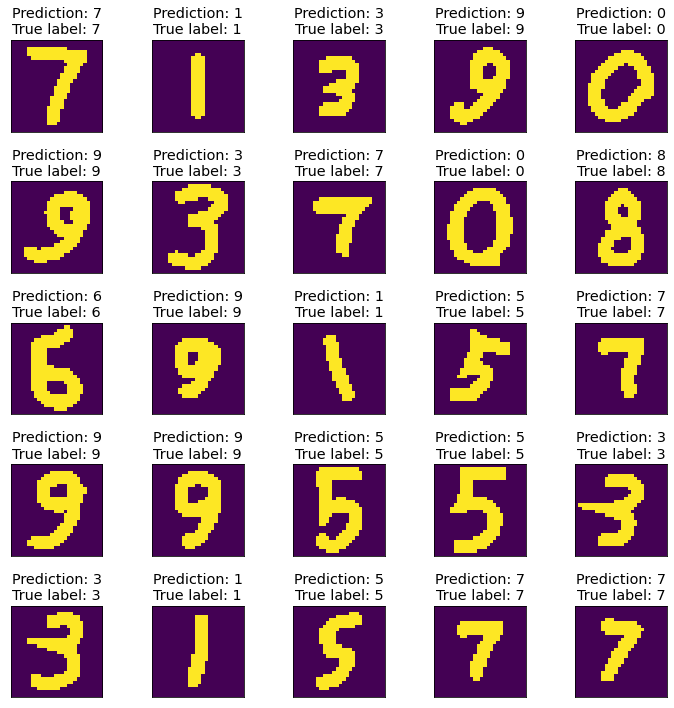

In [30]:
rows, cols = 5, 5

fig, axes = plt.subplots(rows, cols)
fig.figsize=(15, 15)    

indices = np.random.choice(len(images), rows * cols)
counter = 0
    
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(images[indices[counter]])
        axes[i, j].set_title(f"Prediction: {predictions[indices[counter]]}\n"
                             f"True label: {labels[indices[counter]]}")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        counter += 1
    
plt.tight_layout()
plt.show()

##### Plotting wrong predictions

In [31]:
wrong_predictions = list(filter(lambda x: x[1][0] != x[1][1], list(enumerate(zip(predictions, labels)))))

In [32]:
len(wrong_predictions)

54

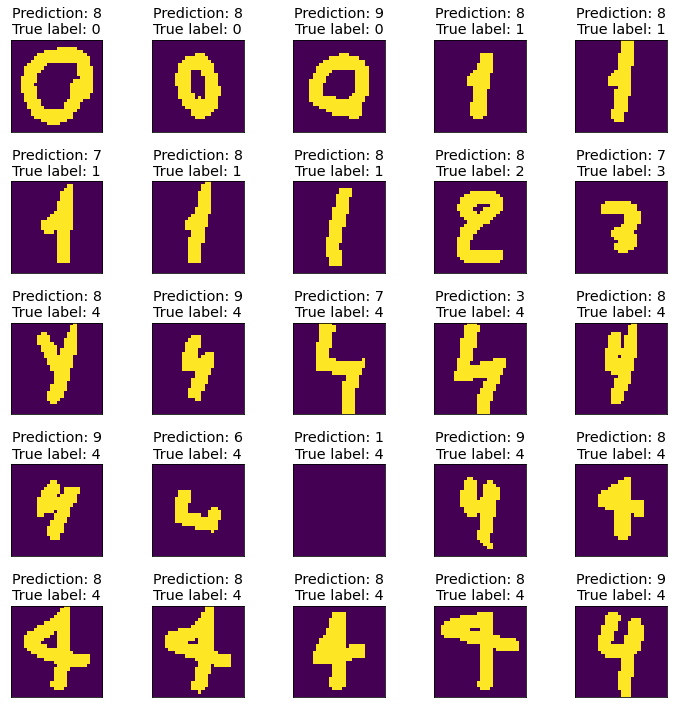

In [33]:
cols, rows = 5, 5

fig, axes = plt.subplots(rows, cols)
fig.figsize=(15, 15)    

counter = 0

for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(images[wrong_predictions[counter][0]])
        axes[i, j].set_title(f"Prediction: {wrong_predictions[counter][1][0]}\n"
                             f"True label: {wrong_predictions[counter][1][1]}")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        counter += 1
    
plt.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

conf_mat = confusion_matrix(labels, predictions) 

In [35]:
conf_mat

array([[ 97,   0,   0,   0,   0,   0,   0,   0,   2,   1],
       [  0,  93,   0,   0,   0,   0,   0,   1,   4,   0],
       [  0,   0,  99,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0, 100,   0,   0,   0,   1,   0,   0],
       [  0,   1,   0,   1,  84,   0,   1,   1,   7,   4],
       [  0,   1,   0,   6,   0, 103,   0,   0,   1,   0],
       [  0,   3,   0,   0,   0,   2,  83,   0,   1,   0],
       [  0,   3,   1,   0,   0,   0,   0, 106,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,  92,   0],
       [  0,   0,   0,   2,   0,   0,   0,   0,   8, 102]], dtype=int64)

In [36]:
class_report = classification_report(labels, predictions, output_dict=True)

class_report

{'0': {'precision': 1.0,
  'recall': 0.97,
  'f1-score': 0.9847715736040609,
  'support': 100},
 '1': {'precision': 0.9117647058823529,
  'recall': 0.9489795918367347,
  'f1-score': 0.9300000000000002,
  'support': 98},
 '2': {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99, 'support': 100},
 '3': {'precision': 0.9174311926605505,
  'recall': 0.9900990099009901,
  'f1-score': 0.9523809523809524,
  'support': 101},
 '4': {'precision': 1.0,
  'recall': 0.8484848484848485,
  'f1-score': 0.9180327868852458,
  'support': 99},
 '5': {'precision': 0.9809523809523809,
  'recall': 0.9279279279279279,
  'f1-score': 0.9537037037037037,
  'support': 111},
 '6': {'precision': 0.9880952380952381,
  'recall': 0.9325842696629213,
  'f1-score': 0.9595375722543353,
  'support': 89},
 '7': {'precision': 0.9724770642201835,
  'recall': 0.9636363636363636,
  'f1-score': 0.9680365296803652,
  'support': 110},
 '8': {'precision': 0.7931034482758621,
  'recall': 0.989247311827957,
  'f1-score': 0.88038277

#### One-vs-rest classifier on MNIST test dataset

In [37]:
classifier.score(test_images_flat, test_labels)

0.9138

In [38]:
predictions = classifier.predict(test_images_flat)

conf_mat = confusion_matrix(test_labels, predictions) 

In [39]:
conf_mat

array([[ 961,    0,    1,    2,    0,    5,    5,    3,    1,    2],
       [   0, 1113,    2,    2,    0,    1,    5,    2,   10,    0],
       [   9,   11,  906,   24,    9,    7,   17,   10,   33,    6],
       [   6,    1,   14,  917,    1,   33,    4,    9,   14,   11],
       [   1,    3,    4,    2,  908,    2,   13,    1,    5,   43],
       [  11,    2,    0,   22,    8,  802,   17,    4,   19,    7],
       [  12,    3,    7,    2,    5,   20,  908,    0,    1,    0],
       [   5,   11,   22,    6,   10,    4,    1,  925,    3,   41],
       [  15,   17,    7,   30,    9,   66,   11,    7,  798,   14],
       [  13,    9,    0,   15,   31,   19,    0,   17,    5,  900]],
      dtype=int64)

In [40]:
class_report = classification_report(test_labels, predictions, output_dict=True)

In [41]:
class_report

{'0': {'precision': 0.9303000968054211,
  'recall': 0.9806122448979592,
  'f1-score': 0.9547938400397415,
  'support': 980},
 '1': {'precision': 0.9512820512820512,
  'recall': 0.9806167400881057,
  'f1-score': 0.9657266811279828,
  'support': 1135},
 '2': {'precision': 0.940809968847352,
  'recall': 0.877906976744186,
  'f1-score': 0.9082706766917292,
  'support': 1032},
 '3': {'precision': 0.8972602739726028,
  'recall': 0.907920792079208,
  'f1-score': 0.9025590551181103,
  'support': 1010},
 '4': {'precision': 0.9255861365953109,
  'recall': 0.924643584521385,
  'f1-score': 0.9251146204788588,
  'support': 982},
 '5': {'precision': 0.8362877997914494,
  'recall': 0.899103139013453,
  'f1-score': 0.8665586169638033,
  'support': 892},
 '6': {'precision': 0.9255861365953109,
  'recall': 0.9478079331941545,
  'f1-score': 0.9365652398143373,
  'support': 958},
 '7': {'precision': 0.9458077709611452,
  'recall': 0.8998054474708171,
  'f1-score': 0.9222333000997008,
  'support': 1028},
 

#### One-vs-rest classifier on drawn images

In [42]:
classifier.score(images_flat, labels)

0.5074037512339585

In [43]:
predictions = classifier.predict(images_flat)

conf_mat = confusion_matrix(labels, predictions) 

In [44]:
conf_mat

array([[87,  0,  0, 12,  0,  0,  0,  0,  0,  1],
       [ 0, 60,  0,  5,  0,  5,  2,  0, 26,  0],
       [ 0,  0, 78,  8,  0,  2,  5,  0,  7,  0],
       [ 0,  0,  2, 93,  0,  0,  0,  0,  1,  5],
       [ 0,  0,  1, 30, 16,  3, 27,  0, 13,  9],
       [ 0,  0,  1, 76,  0, 29,  3,  1,  0,  1],
       [ 0,  0,  0,  0,  0, 21, 62,  0,  5,  1],
       [ 0,  2,  0, 78,  0,  3,  0, 23,  3,  1],
       [ 1,  0,  0, 25,  0,  1,  2,  0, 64,  0],
       [ 2,  0,  0, 88,  0,  0,  0,  0, 20,  2]], dtype=int64)

In [45]:
class_report = classification_report(labels, predictions, output_dict=True)

In [46]:
class_report

{'0': {'precision': 0.9666666666666667,
  'recall': 0.87,
  'f1-score': 0.9157894736842105,
  'support': 100},
 '1': {'precision': 0.967741935483871,
  'recall': 0.6122448979591837,
  'f1-score': 0.75,
  'support': 98},
 '2': {'precision': 0.9512195121951219,
  'recall': 0.78,
  'f1-score': 0.8571428571428571,
  'support': 100},
 '3': {'precision': 0.22409638554216868,
  'recall': 0.9207920792079208,
  'f1-score': 0.3604651162790698,
  'support': 101},
 '4': {'precision': 1.0,
  'recall': 0.16161616161616163,
  'f1-score': 0.27826086956521745,
  'support': 99},
 '5': {'precision': 0.453125,
  'recall': 0.26126126126126126,
  'f1-score': 0.3314285714285714,
  'support': 111},
 '6': {'precision': 0.6138613861386139,
  'recall': 0.6966292134831461,
  'f1-score': 0.6526315789473685,
  'support': 89},
 '7': {'precision': 0.9583333333333334,
  'recall': 0.20909090909090908,
  'f1-score': 0.34328358208955223,
  'support': 110},
 '8': {'precision': 0.460431654676259,
  'recall': 0.688172043010